![Houses Stock Photo](../assets/forsale)


# <a id='toc1_'></a>[Ames Iowa Housing Sale Price Prediction OLS Model](#toc0_)

___

**Table of contents**<a id='toc0_'></a>    
- [Ames Iowa Housing Sale Price Prediction OLS Model](#toc1_)    
  - [Imports](#toc1_1_)    
  - [Global Configs](#toc1_2_)    
    - [Feature categorization](#toc1_2_1_)    
      - [Neighborhood Classification](#toc1_2_1_1_)    
    - [Cleaning](#toc1_2_2_)    
    - [Transforming](#toc1_2_3_)    
  - [Funcs](#toc1_3_)    
      - [Cleaning](#toc1_3_1_1_)    
      - [Features:](#toc1_3_1_2_)    
  - [OLS](#toc1_4_)    
      - [Load and Clean data:](#toc1_4_1_1_)    
      - [Feature Engineering](#toc1_4_1_2_)    
        - [Feature Correlation Matrix](#toc1_4_1_2_1_)    
      - [Fit Model & Obtain Training Scores](#toc1_4_1_3_)    
  - [Ridge and LASSO Regularization](#toc1_5_)    
    - [Ridge](#toc1_5_1_)    
    - [Lasso](#toc1_5_2_)    
  - [Generate Output](#toc1_6_)    
- [Model Evaluations](#toc2_)    
    - [Load in Coefficient Data](#toc2_1_1_)    
  - [Shapley Plots](#toc2_2_)    
    - [OLS](#toc2_2_1_)    
      - [Interpretation of OLS SHAP plots](#toc2_2_1_1_)    
    - [Ridge and Lasso](#toc2_2_2_)    
  - [LINEM Assumptions](#toc2_3_)    
    - [Linearity](#toc2_3_1_)    
    - [Independence](#toc2_3_2_)    
    - [Normally Distributed Errors](#toc2_3_3_)    
    - [Equal Variance of Errors](#toc2_3_4_)    
    - [Multicolinearity](#toc2_3_5_)    
  - [Conclusions](#toc2_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

___

## <a id='toc1_1_'></a>[Imports](#toc0_)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

## <a id='toc1_2_'></a>[Global Configs](#toc0_)

### <a id='toc1_2_1_'></a>[Feature categorization](#toc0_)

> Features are grouped according to the data dictionary at https://jse.amstat.org/v19n3/decock/DataDocumentation.txt

In [3]:
ORDINAL = [
    "lot_shape",
    "utilities",
    "land_slope",
    "overall_qual",
    "overall_cond",
    "exter_cond",
    "exter_qual",
    "bsmt_qual",
    "bsmt_cond",
    "bsmt_exposure",
    "bsmtfin_type_1",
    "bsmtfin_type_2",
    "heating_qc",
    "electrical",
    "kitchen_qual",
    "functional",
    "fireplace_qu",
    "garage_finish",
    "garage_qual",
    "garage_cond",
    "paved_drive",
    "pool_qc",
    "fence"  
]

In [4]:
NOMINAL = [
    "ms_subclass",
    "ms_zoning",
    "land_contour",
    "lot_config",
    "neighborhood",
    "condition_1",
    "condition_2",
    "bldg_type",
    "house_style",
    "roof_style",
    "roof_matl",
    "exterior_1st",
    "exterior_2nd",
    "mas_vnr_type",
    "foundation",
    "heating",
    "central_air",
    "garage_type",
    "misc_feature",
    "sale_type",
]

In [5]:
DISCRETE = [
    "year_built",
    "year_add_or_remod",
    "bsmt_full_bath",
    "bsmt_half_bath",
    "full_bath",
    "half_bath",
    "bedroom",
    "kitchen",
    "totrms_abvgrd",
    'fireplaces',
    "garage_yr_built",
    "garage_cars",
    "mo_sold",
    "yr_sold"
]

In [6]:
CONTINUOUS = [
    "lot_frontage",
    "lot_area",
    "mas_vnr_area",
    "bsmtfin_sf_1"
    "bsmtfin_sf_2",
    "bsmt_unf_sf",
    "total_bsmt_sf",
    "1st_flr_sf",
    "2nd_flr_sf",
    "gr_liv_area",
    "low_qual_fin_sf",
    "garage_area",
    "wood_deck_sf",
    "open_porch_sf",
    "enclosed_porch_sf",
    "3-san_porch",
    "screen_porch",
    "pool_area",
    "misc_val",
    "saleprice"
]

#### <a id='toc1_2_1_1_'></a>[Neighborhood Classification](#toc0_)

> These are defined in the Cleaning and EDA Notebook

In [7]:
LOW_COST = [
    'IDOTRR',
    'BrkSide',
    'OldTown',
    'MeadowV',
    'Edwards',
    'Sawyer',
    'SWISU',
    'NAmes',
    'BrDale',
    'Crawfor']

MID_COST = [
    'Mitchel',
    'NPkVill',
    'Blueste',
    'Landmrk',
    'ClearCr',
    'NWAmes',
    'Greens',
    'GrnHill',
    'SawyerW']

HIGH_COST = [
    'CollgCr',
    'Gilbert',
    'Blmngtn',
    'Veenker',
    'Timber',
    'Somerst',
    'StoneBr',
    'NridgHt',
    'NoRidge']

___

### <a id='toc1_2_2_'></a>[Cleaning](#toc0_)

> Explore the creation of these more in the Cleaning and EDA Notebook

In [8]:
MEAN_IMPUTE_COLS = [
    "garage_area",
    "bsmtfin_sf_1",
    "bsmtfin_sf_2",
    "bsmt_unf_sf",
    "total_bsmt_sf",
    "bsmt_full_bath",
    "bsmt_half_bath",
    "garage_cars",
    "mas_vnr_area",
]

In [9]:
FILL_NA = [
    "bsmt_qual",
    "bsmt_cond",
    "bsmt_exposure",
    "bsmtfin_type_1",
    "bsmtfin_type_2",
    "fireplace_qu",
    "garage_type",
    "garage_finish",
    "garage_qual",
    "garage_cond",
    "pool_qc",
    "fence",
    "misc_feature",
]


___

### <a id='toc1_2_3_'></a>[Transforming](#toc0_)

In [10]:
# Custom Features
# Columns that will be used to construct custom features for the model, but then dropped to reduce multicolinearity
FEATURE_COLS = [
    "year_remod_or_add",
    "bsmt_full_bath",
    "bsmt_half_bath",
    "full_bath",
    "half_bath",
    "garage_area",
    "gr_liv_area",
    "pool_area",
    "total_bsmt_sf",
    # "neighborhood",
    # "location",
    "lot_shape",
    "land_contour",
    "condition_1",
    "condition_2",
    "yr_sold"
]


In [11]:
# Ordinal and Nominal explanatory variables to be cast to dummy columns
OHE_COLS = list(
    set([*NOMINAL,*ORDINAL]) - set(FEATURE_COLS)
)

In [12]:
# The polynomial features to include
POLY_COLS = [
    "gr_liv_area",
    "garage_cars",
]

___

## <a id='toc1_3_'></a>[Funcs](#toc0_)

#### <a id='toc1_3_1_1_'></a>[Cleaning](#toc0_)

> These functions are essentially a boiled down version of the steps taken in the Cleaning & EDA Notebook. For discussion on the reasons for certain choices made regarding outlier removal, null value imputation, and dropped features, refer to that document.

In [13]:
def column_mean_impute(df, cols: list):
    for col in cols:
        mean = np.mean(df[col])
        df[col] = df[col].fillna(mean)
    return df

In [14]:
def fill_na_by_dtype(df, cols):
    for col in cols:
        if df[col].dtype in (str, object):
            df[col] = df[col].fillna("None")
        else:
            df[col] = df[col].fillna(0)
    return df

In [15]:
def impute_missings(df):
    df.lot_frontage = df.lot_frontage.fillna(np.mean(df.lot_frontage))
    df = column_mean_impute(df, MEAN_IMPUTE_COLS)
    df = fill_na_by_dtype(df, FILL_NA)
    df.garage_yr_blt = np.where(
        df.garage_yr_blt.isna(), df.year_built, df.garage_yr_blt
    )
    return df

In [16]:
# Discussion on this process can be found in the Cleaning & EDA Notebook
def load_and_clean(file, runtype, return_ids=False):
    df = pd.read_csv(file)
    # Clean columns
    df.columns = df.columns.str.replace(" ", "_").str.lower()
    df.rename(columns={"year_remod/add": "year_remod_or_add"}, inplace=True)

    # Training data processing
    if runtype == "train":
        
        # Remove outliers
        df = df.loc[df.gr_liv_area < 4000]
        
        # "Normalize" saleprice via dropping
        df = df.loc[
                (df.saleprice < df.saleprice.quantile(.96)) &
                (df.saleprice > df.saleprice.quantile(.01))
            ]
        
        # Remove unneeded columns + street and alley because they are mostly missing
        df.drop(columns=['pid','street','alley','id'],axis=1,inplace=True)
        
        # Remove non-resedential properties:
        non_res = ['C (all)', 'I (all)', 'A (agr)']
        df = df.loc[df.ms_zoning.apply(lambda x: x not in non_res)]
        
        df = impute_missings(df)
        
        X = df.drop(columns="saleprice")
        y = df.saleprice
        return X, y
    
    if runtype == "test":
        df = impute_missings(df)
        if return_ids:
            return df, df.id
        else:
            return df

#### <a id='toc1_3_1_2_'></a>[Features:](#toc0_)

In [17]:
def add_cost_group(x):
    if x in LOW_COST:
        return 1
    if x in MID_COST:
        return 2
    if x in HIGH_COST:
        return 3

In [18]:
def add_OHE_cols(Xtrain, Xtest):
    # OHE Cols
    Xtrain = pd.get_dummies(data=Xtrain, columns=OHE_COLS, drop_first=True)
    Xtest = pd.get_dummies(data=Xtest, columns=OHE_COLS, drop_first=True)

    # Standardize Dummies between Test and Train --> Model won't work otherwise!
    Xtrain.drop(
        columns=[x for x in Xtrain.columns if not x in Xtest.columns], inplace=True
    )
    Xtest.drop(
        columns=[x for x in Xtest.columns if not x in Xtrain.columns], inplace=True
    )
    return Xtrain, Xtest

In [19]:
def get_poly_features(Xtrain, Xtest): # columnwise polynomial feature transformer
    
    # instantiate PF
    pf = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

    # fit/transform data
    Xtrainpf = pd.DataFrame(pf.fit_transform(Xtrain[POLY_COLS]))
    Xtestpf = pd.DataFrame(pf.transform(Xtest[POLY_COLS]))

    # clean up columns
    Xtrainpf.columns = map(str,Xtrainpf.columns)
    Xtestpf.columns = map(str, Xtestpf.columns)

    return Xtrainpf, Xtestpf

In [20]:
def engineer_features(df):
    
    # age of house (2010 is the year this dataset came out I believe [per https://jse.amstat.org/v19n3/decock/DataDocumentation.txt])
    # if the house hasn't been remodled or renovated, year_remod_or_add = year_built
    df['age'] = df.yr_sold - df.year_remod_or_add
    df.drop(columns=['year_remod_or_add','yr_sold'],inplace=True)
    
    # total bathrooms
    df['bathrooms'] = (
            df["bsmt_full_bath"] + 
            (df["bsmt_half_bath"]*.5) +
            df["full_bath" ]+
            (df["half_bath"]*.5)
        )
    df.drop(columns=[
        "bsmt_full_bath",
        "bsmt_half_bath",
        "full_bath",
        "half_bath"],
        inplace=True)
    
    # dummify pool
    df['pool'] = (df.pool_area > 0)*1
    df.drop(columns = [
            'pool_area',
    ])
    
    # dummify regular lot shape
    df['regular_lot'] = df['lot_shape'].apply(lambda x: 1 if 'Reg' in x else 0)
    df.drop('lot_shape',axis=1,inplace=True)
    
    # dummify land contour
    df['level_contour'] = df['land_contour'].apply(lambda x: 1 if 'Lvl' in x else 0)
    df.drop('land_contour',axis=1,inplace=True)
    
    # dummy for conditions 1 & 2 to designate proximity to desirable features
    df['pos_feat_nb'] = (
        (
            ( 
                df.condition_1.apply(lambda x: 1 if x in ['Artery','Feedr','PosN','PosA'] else 0)
                + df.condition_2.apply(lambda x: 1 if x in ['Artery','Feedr','PosN','PosA'] else 0)
            )>0 # if has at least 1 pos feat nb --> bool
        )*1 # back to int
    )
    df.drop(columns=['condition_1','condition_2'], inplace=True)
    
    # Features that decreased performance:
    # ========================================================================
    # Add location-cost group:
    # df['n_score'] = df.neighborhood.map(add_cost_group)
    # df.drop('neighborhood', axis=1, inplace=True)
    
    # location_vars = ['overall_qual','year_built','gr_liv_area']    
    # df['location'] = sum([stats.zscore(df[col]) for col in location_vars])
    
    # total sqft:
    # df['total_area'] = (
    #     df["total_bsmt_sf"] + 
    #     df["gr_liv_area"] + 
    #     df["garage_area"]
    # )
    
    # df.drop(columns=[
    #     "total_bsmt_sf",
    #     "gr_liv_area",
    #     "garage_area",
    # ], inplace = True)
    
    return df

## <a id='toc1_4_'></a>[OLS](#toc0_)

#### <a id='toc1_4_1_1_'></a>[Load and Clean data:](#toc0_)

In [21]:
# FOR TESTING:
trainfile = "../datasets/train.csv"
X, y = load_and_clean(trainfile, "train")
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=.3,random_state=1234)

#### <a id='toc1_4_1_2_'></a>[Feature Engineering](#toc0_)

In [22]:
# Add custom features
Xtrain = engineer_features(Xtrain)
Xtest = engineer_features(Xtest)

# One Hot Encode
Xtrain, Xtest = add_OHE_cols(Xtrain, Xtest)

# Add Polynomial Features
trainpf, testpf = get_poly_features(Xtrain, Xtest)
Xtrain = Xtrain.join(trainpf).fillna(0)
Xtest = Xtest.join(testpf).fillna(0)

##### <a id='toc1_4_1_2_1_'></a>[Feature Correlation Matrix](#toc0_)

> This graph is giant, but it does demonstrate limited multicolinearity across our features.

<a id='featcorrmat'></a>

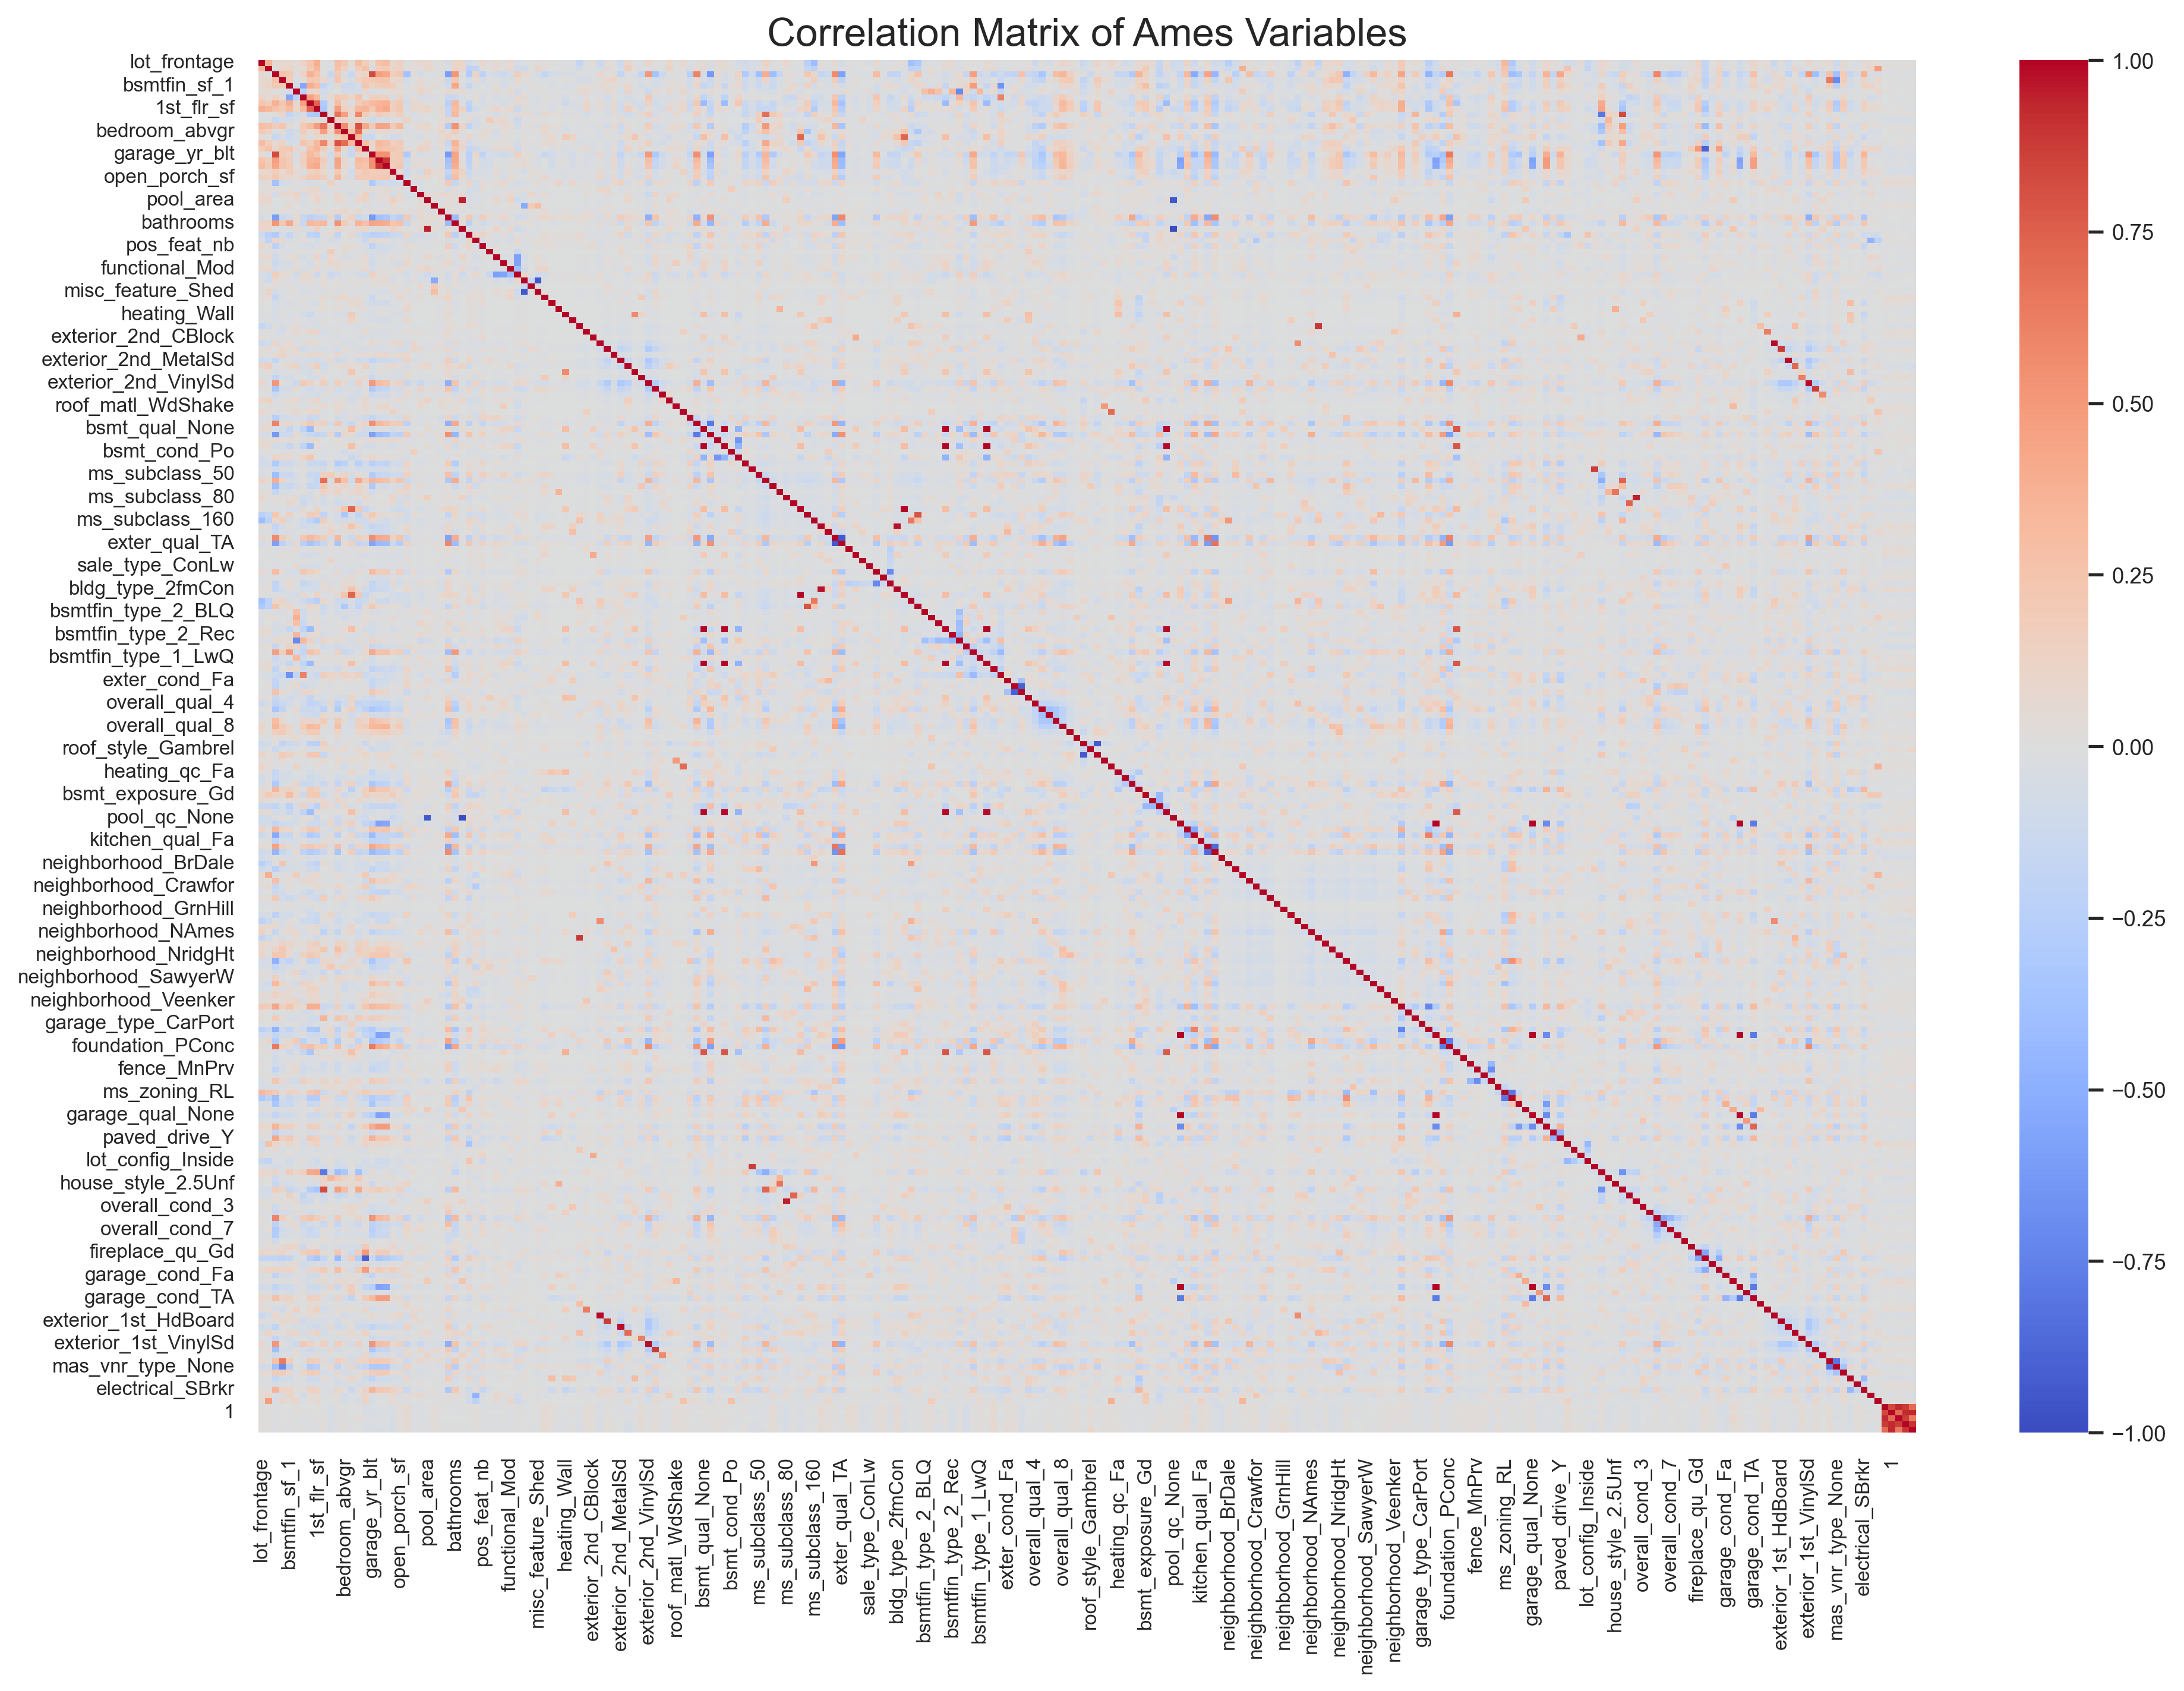

In [23]:
plt.figure(figsize=(15,10), dpi=300)
sns.set(font_scale=0.8)
sns.heatmap(Xtrain.corr(), cmap='coolwarm')
plt.title("Correlation Matrix of Ames Variables", fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);

In [24]:
# Count of highly positively correlated features (excluding self-correlations)
# Div by 2 to avoid double counting

((Xtrain.corr() > .50).sum().sum() - len(Xtrain.corr()))/2

103.0

In [25]:
# Count of highly negatively correlated features
((Xtrain.corr() < -.50).sum().sum())/2 

62.0

In [26]:
# Size of feature correlation space
(Xtrain.corr() >= -1).sum().sum()

57600

#### <a id='toc1_4_1_3_'></a>[Fit Model & Obtain Training Scores](#toc0_)

In [27]:
lr = LinearRegression()
lr.fit(Xtrain, ytrain)

LinearRegression()

In [28]:
# Training Score
train_preds = lr.predict(Xtrain)
print("Train R2:   ",lr.score(Xtrain,ytrain))
print("Train RMSE: ",np.sqrt(metrics.mean_squared_error(ytrain, train_preds)))

Train R2:    0.9434867387404686
Train RMSE:  14167.722656370759


In [29]:
# NOTE: ONLY FOR TESTING PURPOSES (REQUIRES TRAIN TEST SPLIT)
# Testing Score
preds = lr.predict(Xtest)
print("Test R2:   ", lr.score(Xtest,ytest))
print("Test RMSE: ",np.sqrt(metrics.mean_squared_error(ytest,preds)))

Test R2:    0.8968671244493323
Test RMSE:  19082.642980347988


In [30]:
# # Feature-Coefficient Output:
# pd.DataFrame(
#     list(zip(lr.feature_names_in_,lr.coef_)),
#     columns=['Feature','Coef']
# ).to_csv('featurecoefs.csv',index=False)

___

## <a id='toc1_5_'></a>[Ridge and LASSO Regularization](#toc0_)

### <a id='toc1_5_1_'></a>[Ridge](#toc0_)

In [31]:
sc = StandardScaler()
Ztrain = sc.fit_transform(Xtrain)
Ztest = sc.transform(Xtest)

In [32]:
r_alphas = np.logspace(0, 3, 1000)
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)
ridge_cv = ridge_cv.fit(Ztrain, ytrain)

In [33]:
ridge_cv.alpha_

179.99285067824763

In [34]:
print(ridge_cv.score(Ztrain, ytrain))
print(ridge_cv.score(Ztest, ytest))

0.9367484392229927
0.8993693907140842


In [35]:
train_preds = ridge_cv.predict(Ztrain)
test_preds = ridge_cv.predict(Ztest)
print("Train RMSE: ",np.sqrt(metrics.mean_squared_error(ytrain,train_preds)))
print("Test RMSE : ",np.sqrt(metrics.mean_squared_error(ytest,test_preds)))

Train RMSE:  14988.579810414562
Test RMSE :  18849.724744483807


Hey! Looks like our model benefitted from the ridge regression.

### <a id='toc1_5_2_'></a>[Lasso](#toc0_)

In [36]:
l_alphas = np.logspace(2, 5, 3000)
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=1500)
lasso_cv.fit(Ztrain, ytrain);

In [37]:
lasso_cv.alpha_

521.4817084797022

In [38]:
print(lasso_cv.score(Ztrain, ytrain))
print(lasso_cv.score(Ztest, ytest))

0.930241250141858
0.902082690286093


In [39]:
train_preds = lasso_cv.predict(Ztrain)
test_preds = lasso_cv.predict(Ztest)
print("Train RMSE: ",np.sqrt(metrics.mean_squared_error(ytrain,train_preds)))
print("Test RMSE : ",np.sqrt(metrics.mean_squared_error(ytest,test_preds)))

Train RMSE:  15740.705951275646
Test RMSE :  18593.866050203284


And the LASSO performed even better! Hurrah for regularization. I also enjoy how low the variance here is, the best it's been for any of our models.

## <a id='toc1_6_'></a>[Generate Output](#toc0_)

> This function runs the whole above process but on the entire training and testing csv's in ../datasets and generates predictions for each of the three models. It also creates an output file of the feature coefficients from each of the models for our model evaluations.

In [40]:
def create_predictions():
    # FOR REAL SUBMISSIONS:
    trainfile = "../datasets/train.csv"
    testfile = "../datasets/test.csv"
    Xtrain, ytrain = load_and_clean(trainfile, "train")
    Xtest, ids = load_and_clean(testfile, "test", return_ids=True)

    # Hand Selected Features
    Xtrain = engineer_features(Xtrain)
    Xtest = engineer_features(Xtest)

    # OHE
    Xtrain, Xtest = add_OHE_cols(Xtrain, Xtest)
    
    # Add Polynomial Features
    trainpf, testpf = get_poly_features(Xtrain, Xtest)
    Xtrain = Xtrain.join(trainpf).fillna(0)
    Xtest = Xtest.join(testpf).fillna(0)

    # Create and fit OLS model to training data
    lr = LinearRegression()
    lr.fit(Xtrain, ytrain)
    
    # Predictions Output
    preds = lr.predict(Xtest)
    p = pd.Series(preds)
    out = pd.DataFrame({"Id": ids, "SalePrice": p})
    out.dropna(inplace=True)
    out.Id = out.Id.astype(int)
    out.to_csv("../output/OLSpredictionsNB.csv", index=False)

    
    #_______________________________________________________
    #-------------------------------------------------------
    # Regularization:
    
    sc = StandardScaler()
    Ztrain = sc.fit_transform(Xtrain)
    Ztest = sc.transform(Xtest)
        
    # ========== Ridge Predictions =========================
    
    r_alphas = np.logspace(0, 5, 500)
    ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

    # Fit model using best ridge alpha
    ridge_cv = ridge_cv.fit(Ztrain, ytrain)
    rcv_preds = ridge_cv.predict(Ztest)
    
    p = pd.Series(rcv_preds)
    out = pd.DataFrame({"Id": ids, "SalePrice": p})
    out.dropna(inplace=True)
    out.Id = out.Id.astype(int)
    out.to_csv("../output/RCVpredictionsNB.csv", index=False)
    
    
    # ========== LASSO Predictions =========================
    l_alphas = np.logspace(0, 5, 3000)
    lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=2000)
    
    lasso_cv.fit(Ztrain, ytrain)
    lcv_preds = lasso_cv.predict(Ztest)
    
    p = pd.Series(lcv_preds)
    out = pd.DataFrame({"Id": ids, "SalePrice": p})
    out.dropna(inplace=True)
    out.Id = out.Id.astype(int)
    out.to_csv("../output/LCVpredictionsNB.csv", index=False)

    
    # Feature-Coefficient Output:
    pd.DataFrame(
        list(zip(lr.feature_names_in_,lr.coef_,ridge_cv.coef_,lasso_cv.coef_)),
        columns=['feature','ols_coef','ridge_coef','lasso_coef']
    ).to_csv('../output/coefs/featurecoefs.csv',index=False)
    

In [41]:
create_predictions()

___

# <a id='toc2_'></a>[Model Evaluations](#toc0_)

### <a id='toc2_1_1_'></a>[Load in Coefficient Data](#toc0_)

In [68]:
coefs = pd.read_csv('../output/coefs/featurecoefs.csv')
coefs.head()

,feature,ols_coef,ridge_coef,lasso_coef
0,lot_frontage,102.798543,2118.842064,1837.112123
1,lot_area,0.565490,3346.651058,3185.312869
2,year_built,351.878881,6007.739880,8804.280160
3,mas_vnr_area,5.932345,1068.340308,731.009654
4,bsmtfin_sf_1,14.672625,5307.423214,5740.231524


## <a id='toc2_2_'></a>[Shapley Plots](#toc0_)

To visualize the impact of our features on predictions, we'll be using the [SHAP library](https://shap.readthedocs.io/). 

> "SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions."

SHAP plots are great because they take into account the scale of the features when calculating individual effects on our predictions. In this case, it's important to be able to interpret the value of our coefficients post-standardization since we've conducted some model regularization during this process. Using the SHAP plots will thus grant us additional insight to the workings of our linear models.

### <a id='toc2_2_1_'></a>[OLS](#toc0_)

In [43]:
import shap

In [44]:
explainer = shap.Explainer(lr,Xtest)
shap_vals = explainer(Xtest)

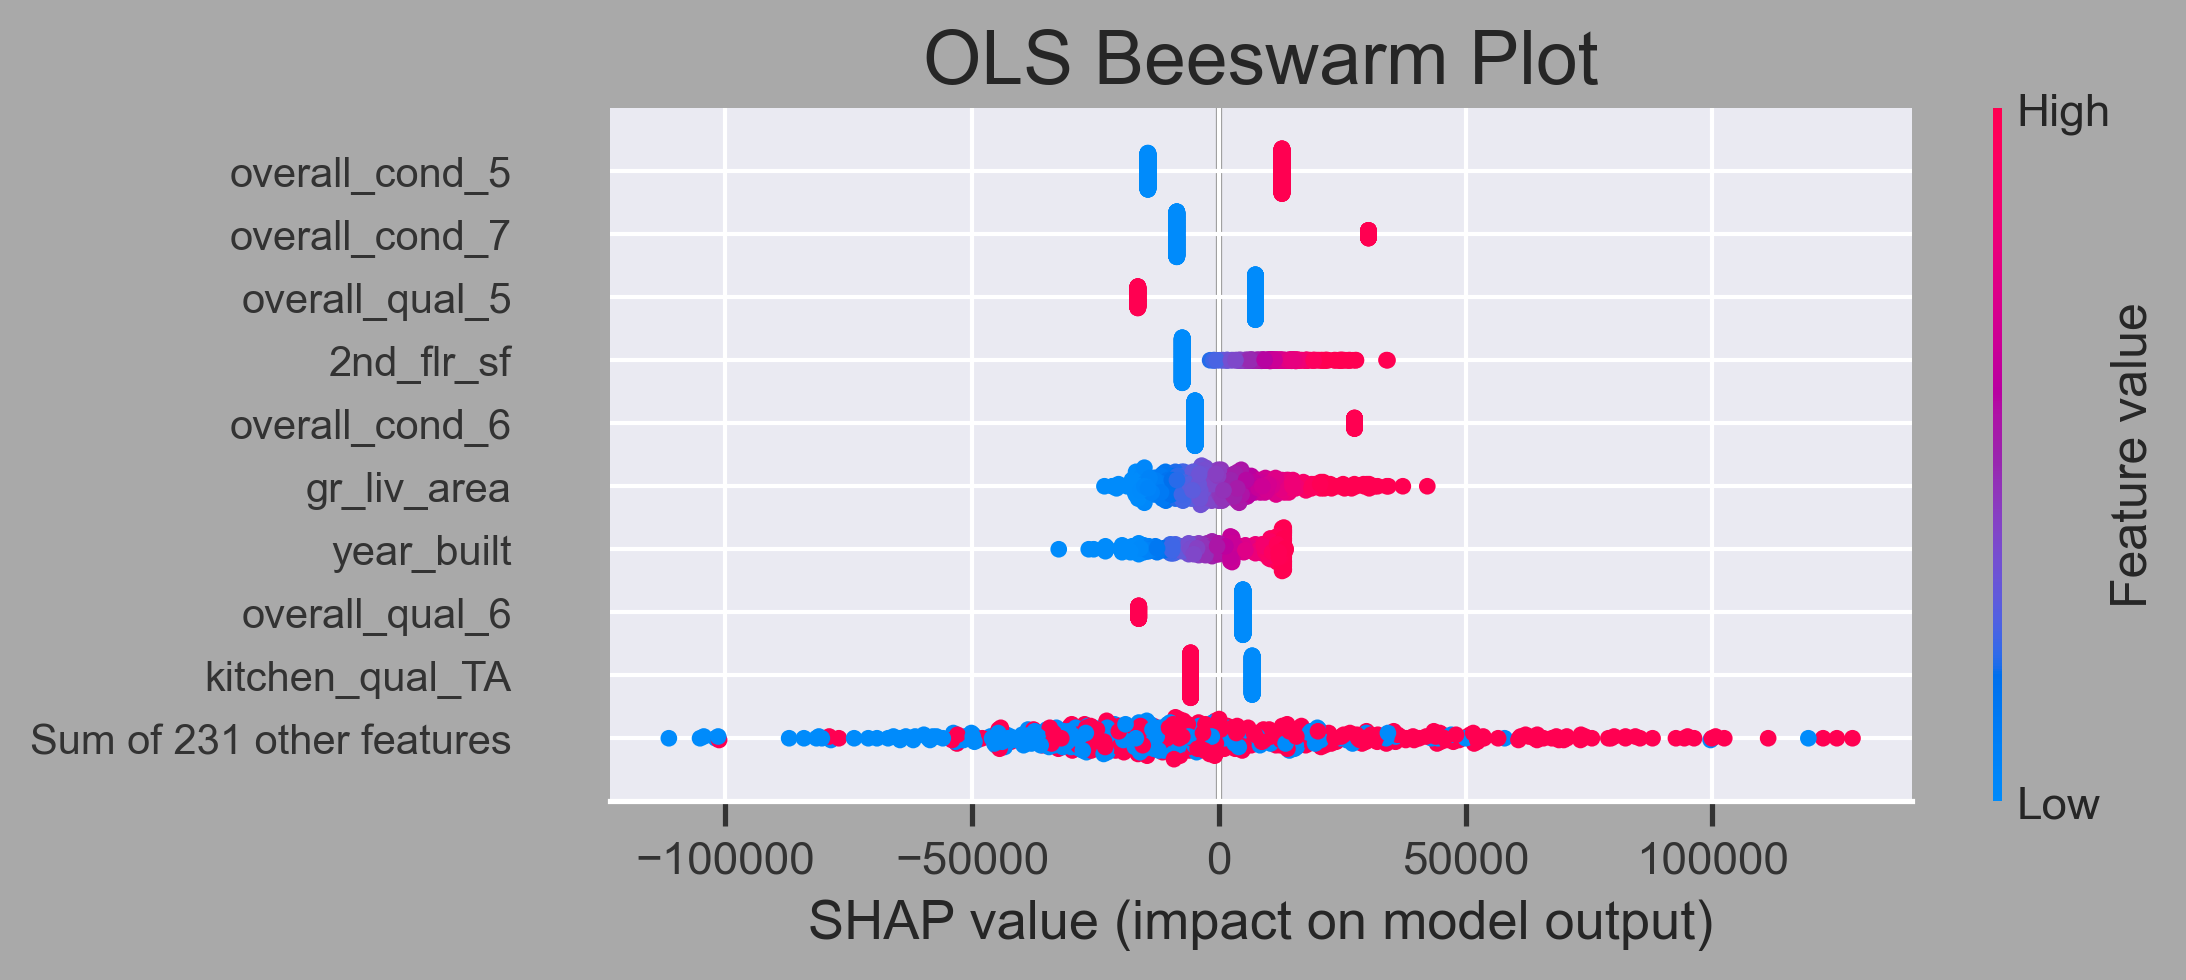

In [45]:
fig = plt.figure(dpi=300, facecolor= 'darkgray')
shap.plots.beeswarm(shap_vals,show=False)
plt.gcf().set_size_inches(7,3)
plt.title('OLS Beeswarm Plot',{'fontsize':18,'font':'arial'})
plt.yticks(size=10)
plt.show()

The above beeswarm plot shows how values of particular features correspond to changes in the model's predictions. 

As we expect, increases in the total area (2nd_flr_sf & gr_liv_area) in general have a positive linear(ish) impact on the predicted values. 

It is interesting to note that the average effect of overall_qual_6 is opposite that of increases in other feature values. When it is true (=1 because this is a dummy column), the value of the prediction decreases. The same goes for kitchen_qual_TA where TA = normal/typical/average. We can see this is true by the color reversal relative to area and age metrics displayed in the graph.

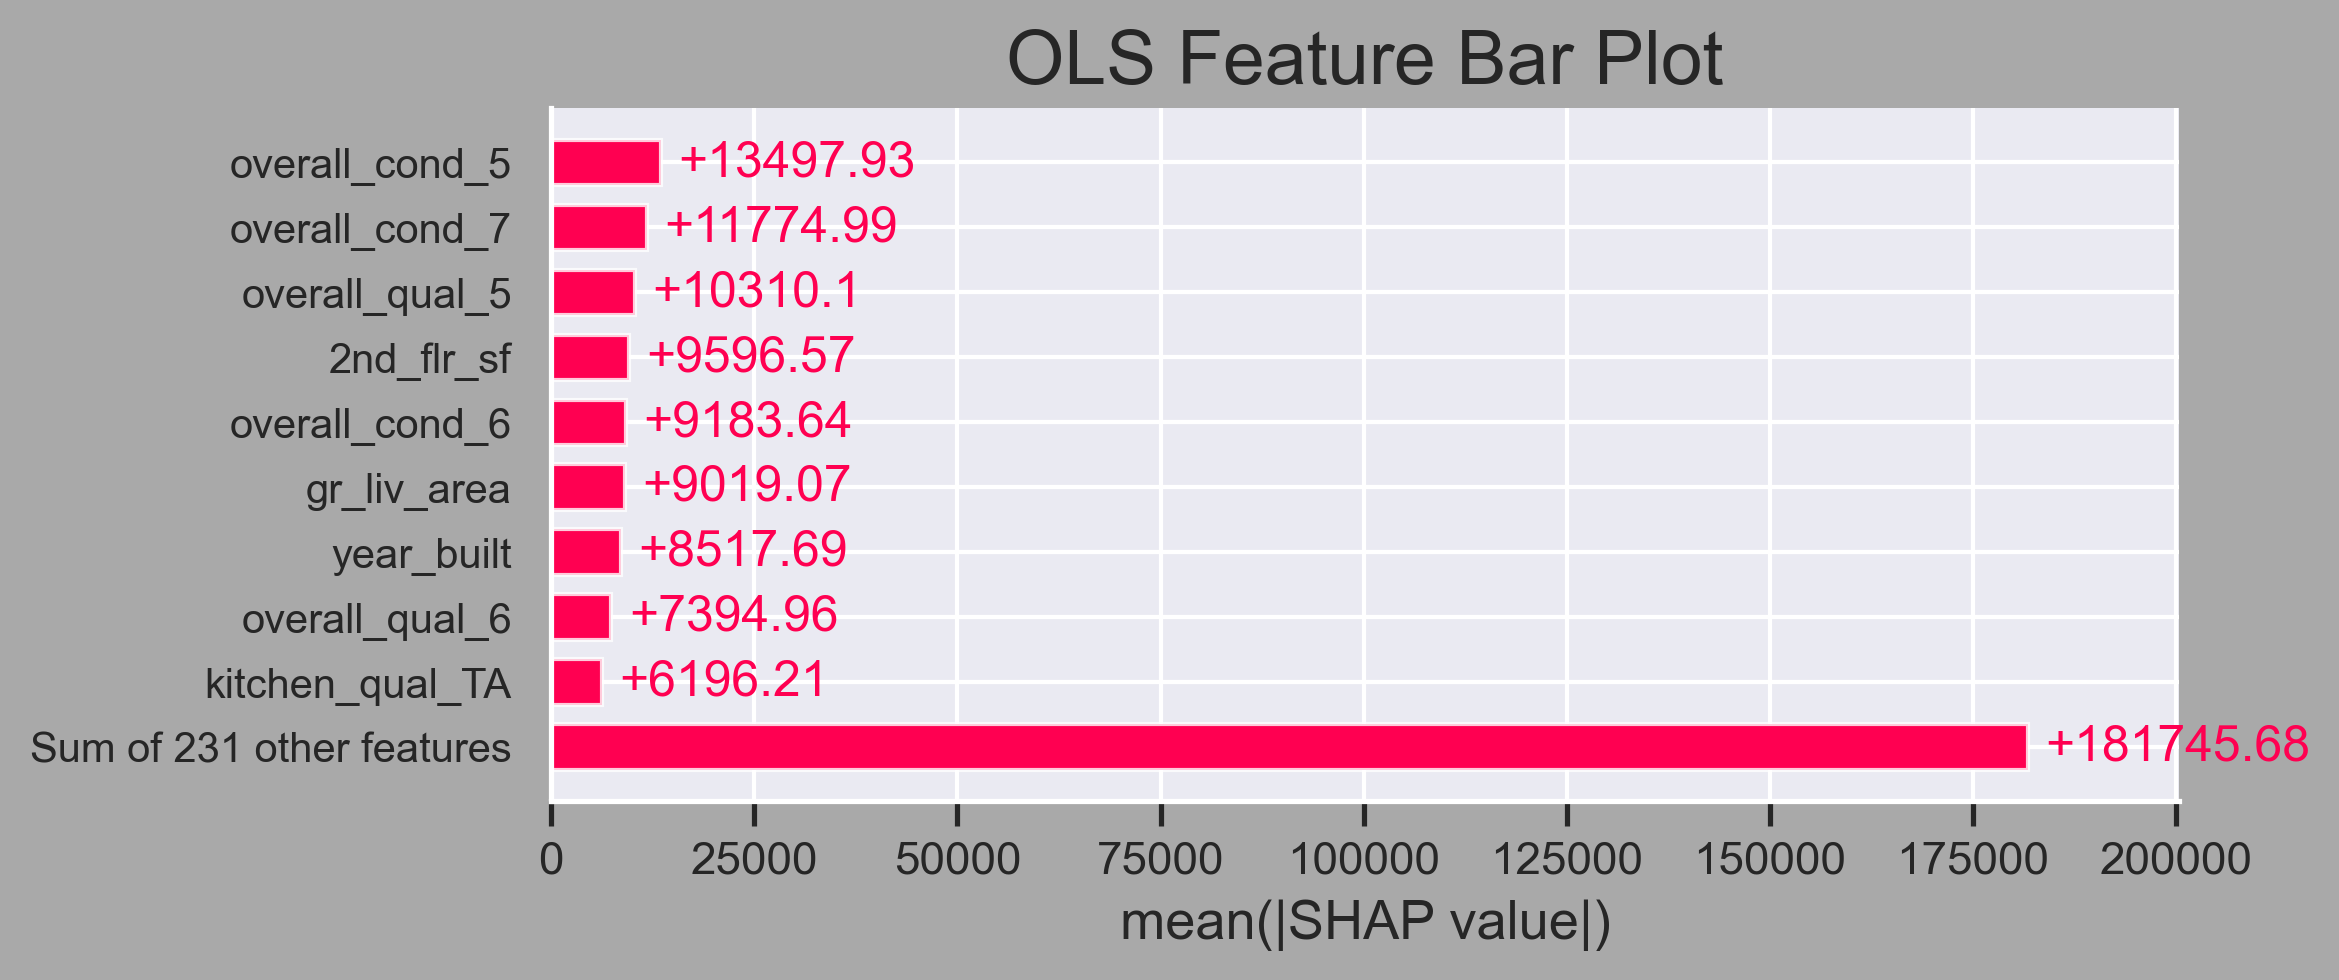

In [46]:
fig = plt.figure(dpi=300, facecolor= 'darkgray')
shap.plots.bar(shap_vals, show=False)
plt.gcf().set_size_inches(7,3)
plt.title('OLS Feature Bar Plot',{'fontsize':18,'font':'arial'})
plt.yticks(size=10)
plt.show()

#### <a id='toc2_2_1_1_'></a>[Interpretation of OLS SHAP plots](#toc0_)

The above graph indicates the 9 most impactful features in the set based on their absolute mean SHAP value calculated using all predictions. As we can see, overall quality and conditions in the middling range of 5-7 appear to be extremely influential across all predictions. 2nd floor area also has a significant positive impact on the prediction value, probably due to the fact that it simultaneously indicates additional space and the presence of a 2-story on the property. Likewise, kitchen quality, the total above grade area, and the year built are quite important to our model's predictions.


More succinctly:

> For each feature *y* on our bar chart, we can expect the value of an individual prediction to increase by the magnitude of the corresponding bar displayed, all else held equal. 




___

### <a id='toc2_2_2_'></a>[Ridge and Lasso](#toc0_)

In [47]:
r_explainer = shap.Explainer(ridge_cv,Ztest)
r_shap_vals = r_explainer(Ztest)

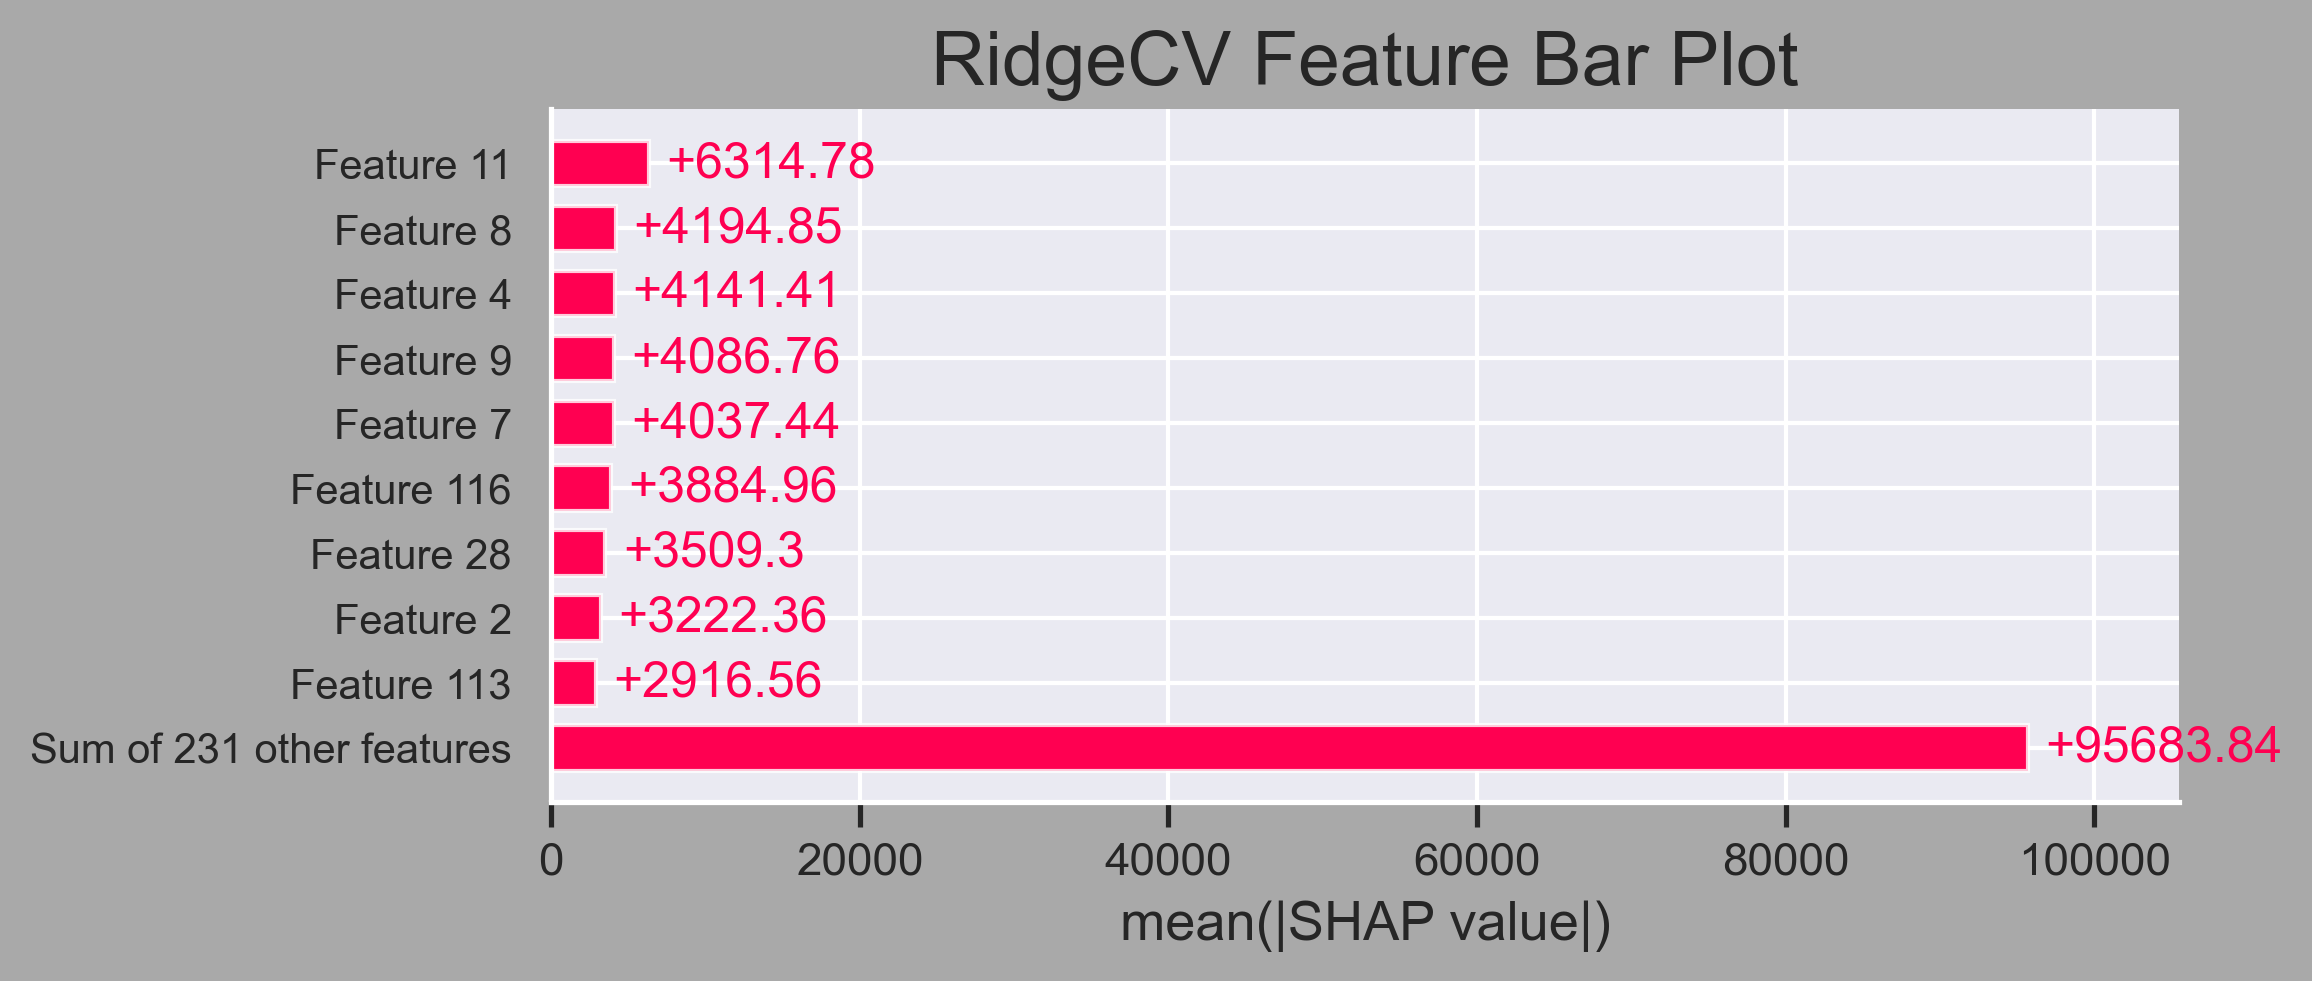

In [48]:
fig = plt.figure(dpi=300, facecolor= 'darkgray')
shap.plots.bar(r_shap_vals, show=False)
plt.gcf().set_size_inches(7,3)
plt.title('RidgeCV Feature Bar Plot',{'fontsize':18,'font':'arial'})
plt.yticks(size=10)
plt.show()

In [49]:
# Recovering feature names!
coefs['feature'].iloc[[11,8,4,9,7,60,28,2,57]].tolist()

['gr_liv_area',
 '1st_flr_sf',
 'bsmtfin_sf_1',
 '2nd_flr_sf',
 'total_bsmt_sf',
 'bsmt_qual_Gd',
 'bathrooms',
 'year_built',
 'roof_matl_WdShake']

___

In [50]:
l_explainer = shap.Explainer(lasso_cv,Ztest)
l_shap_vals = l_explainer(Ztest)

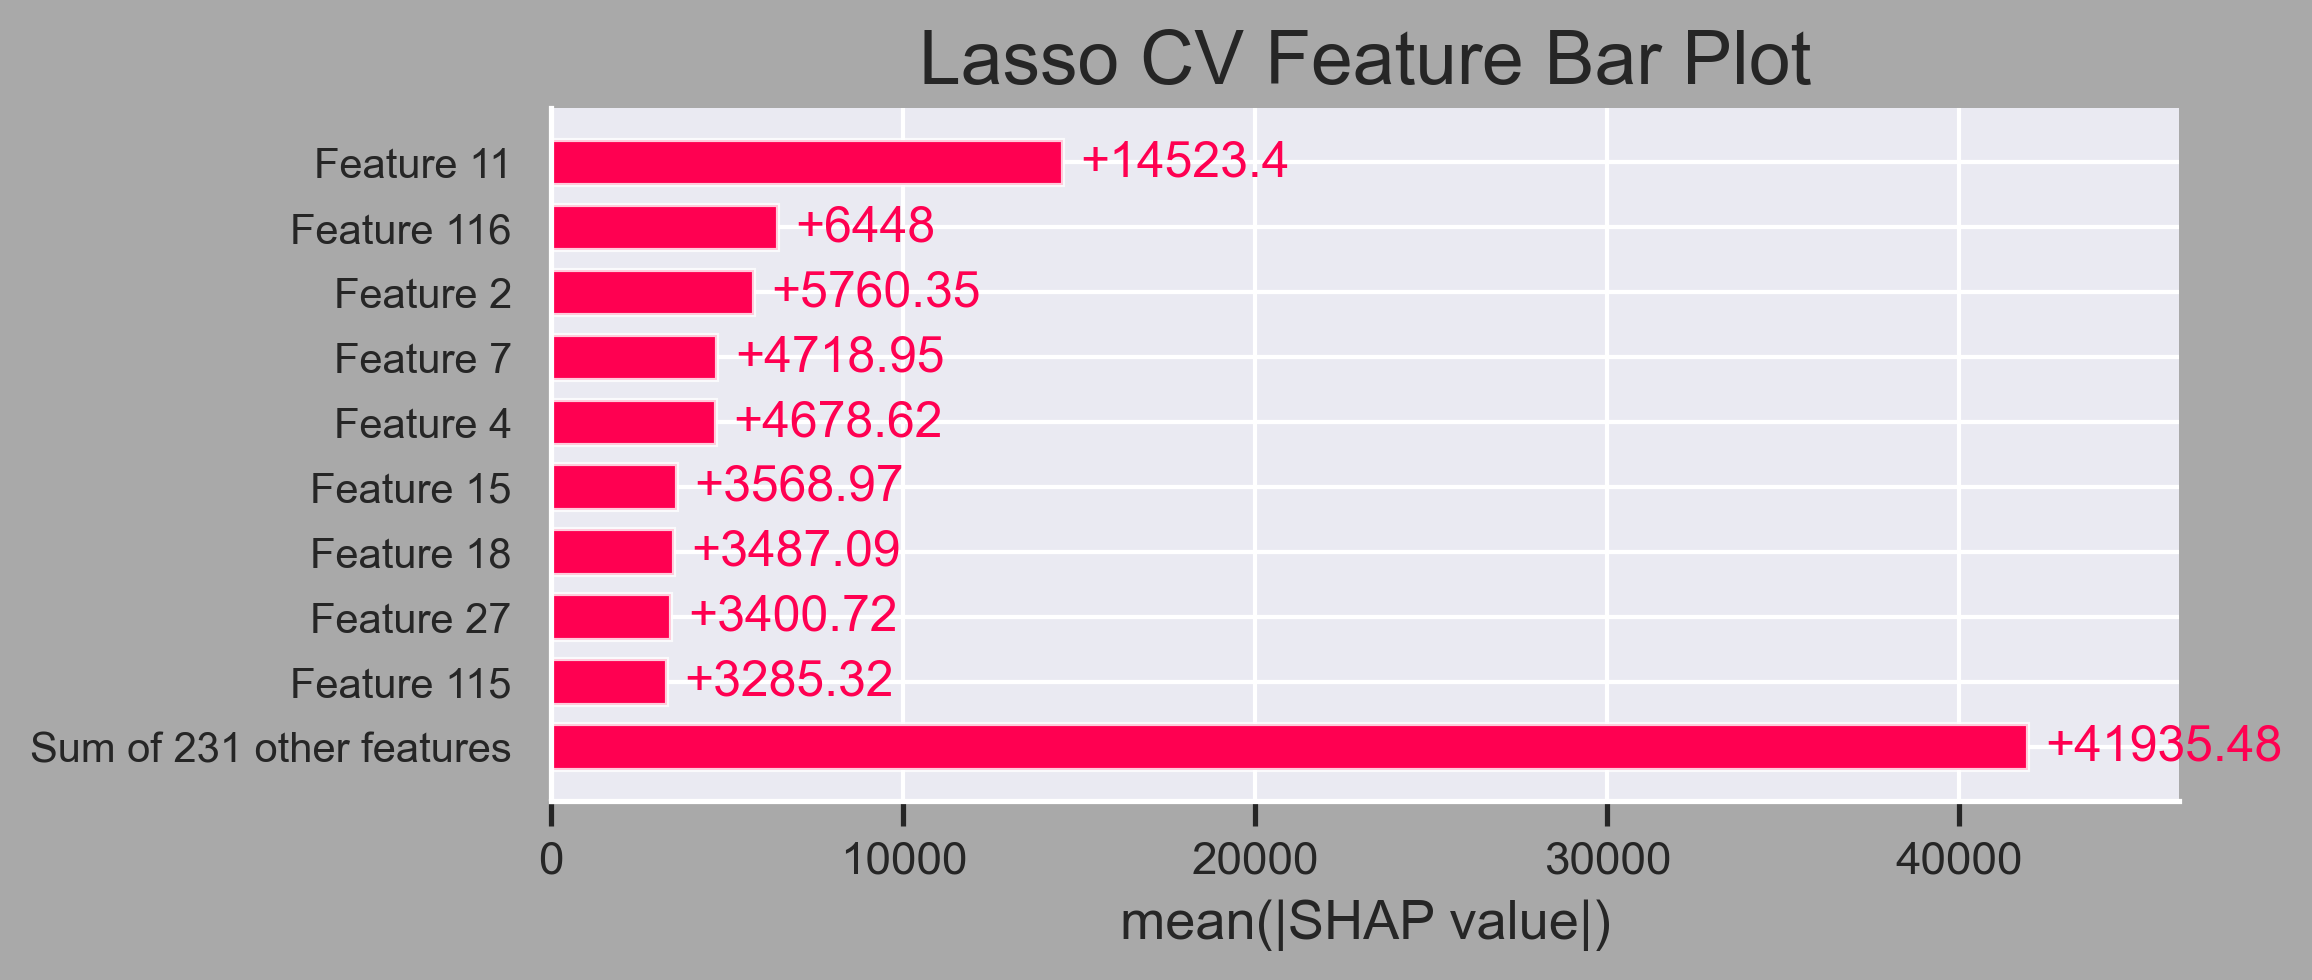

In [51]:
fig = plt.figure(dpi=300, facecolor= 'darkgray')
shap.plots.bar(l_shap_vals, show=False)
plt.gcf().set_size_inches(7,3)
plt.title('Lasso CV Feature Bar Plot',{'fontsize':18,'font':'arial'})
plt.yticks(size=10)
plt.show()

In [52]:
coefs['feature'].iloc[[11,60,2,7,4,15,18,27,59]].tolist()

['gr_liv_area',
 'bsmt_qual_Gd',
 'year_built',
 'total_bsmt_sf',
 'bsmtfin_sf_1',
 'fireplaces',
 'garage_area',
 'age',
 'bsmt_qual_Fa']

___

## <a id='toc2_3_'></a>[LINEM Assumptions](#toc0_)

> Validating that our model is working as intended

### <a id='toc2_3_1_'></a>[Linearity](#toc0_)

In [53]:
# Regenerating these:
preds = lr.predict(Xtest)
resids = ytest - preds

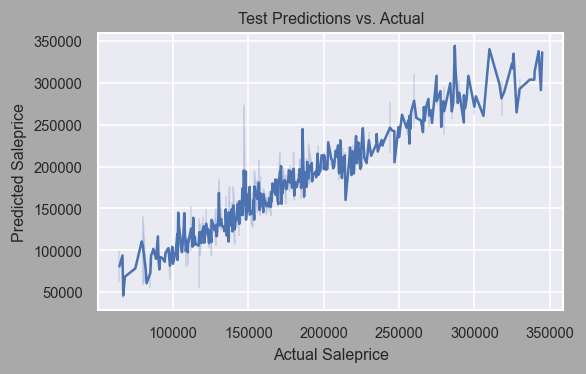

In [54]:
plt.figure(figsize=(5,3),facecolor="darkgray", dpi=120)
plt.title("Test Predictions vs. Actual")
plt.xlabel('Actual Saleprice')
plt.ylabel('Predicted Saleprice')
sns.lineplot(x=ytest, y=preds);

> Interpretation: Our model is roughly linear! (Variance & Errors present, but it is almost a slope of 1)

### <a id='toc2_3_2_'></a>[Independence](#toc0_)

There isn't much we can do here other than assuming that our observations are independent from one another.

### <a id='toc2_3_3_'></a>[Normally Distributed Errors](#toc0_)

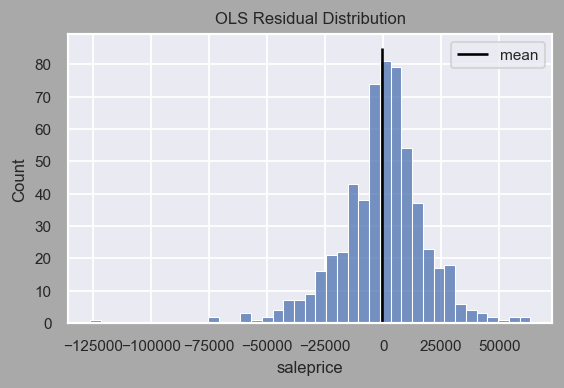

In [55]:
plt.figure(figsize=(5,3),facecolor='darkgray',dpi=125)
sns.histplot(x=resids)
plt.title('OLS Residual Distribution')
plt.vlines(x=np.mean(resids),ymin=0,ymax=85,colors='black',label='mean')
plt.legend();

Though slightly left skew, this clearly shows that the saleprice residuals are normally distributed.

### <a id='toc2_3_4_'></a>[Equal Variance of Errors](#toc0_)

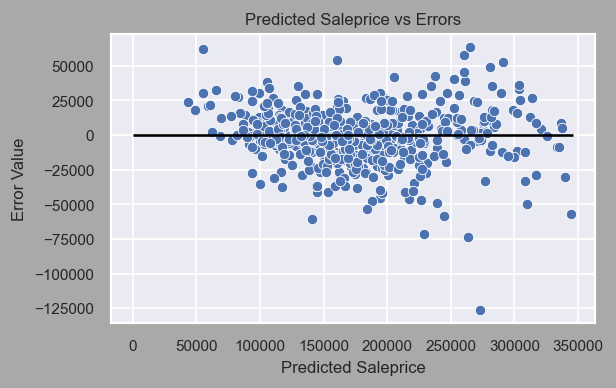

In [56]:
plt.figure(figsize=(5,3),facecolor='darkgray',dpi=125)
sns.scatterplot(x=preds,y=resids)
plt.title('Predicted Saleprice vs Errors')
plt.hlines(y=0,xmin=0,xmax=np.max(preds)+2000,colors='black')
plt.ylabel('Error Value')
plt.xlabel('Predicted Saleprice');

Here, we see limited, though certainly present heteroscedasticity. In large part, our errors are centered around the 0 horizontal line depicted in the graph, lending creedence to our assumption that this information could be modeled linearly in the first place.

### <a id='toc2_3_5_'></a>[Multicolinearity](#toc0_)

![Feature Correlation Matrix](../assets/featurecorrmat.png)

See the discussion about this in the [Feature Engineering](#load-and-clean-data) section.

___

## <a id='toc2_4_'></a>[Conclusions](#toc0_)

In [66]:
coefs.head(20).sort_values(by=['ols_coef','lasso_coef','ridge_coef'], ascending=False).reset_index(drop=True)

,feature,ols_coef,ridge_coef,lasso_coef
0,fireplaces,4896.551929,2877.949989,3253.717625
1,garage_cars,3324.277225,2228.667731,1787.971028
2,year_built,351.878881,6007.739880,8804.280160
3,lot_frontage,102.798543,2118.842064,1837.112123
4,gr_liv_area,27.883812,10099.025109,20093.130367
5,2nd_flr_sf,23.014214,6102.233358,0.000000
6,total_bsmt_sf,17.987138,5878.142539,5614.206100
7,1st_flr_sf,14.674164,5793.595975,0.000000
8,bsmtfin_sf_1,14.672625,5307.423214,5740.231524
9,garage_area,12.595822,2681.755167,2579.096260


In [71]:
coefs['mean_coef'] = (coefs.ols_coef + coefs.ridge_coef + coefs.lasso_coef )/3


In [73]:
coefs[['feature','mean_coef']].head(10).sort_values(by='mean_coef', ascending=False)

,feature,mean_coef
2,year_built,5054.632974
7,total_bsmt_sf,3836.778592
4,bsmtfin_sf_1,3687.442455
1,lot_area,2177.509806
9,2nd_flr_sf,2041.749191
8,1st_flr_sf,1936.090046
0,lot_frontage,1352.917577
3,mas_vnr_area,601.760769
5,bsmtfin_sf_2,440.216790
6,bsmt_unf_sf,-28.921596


> For each feature, we can expect the value of an individual prediction to increase by the magnitude of the corresponding SHAP value, all else held equal. 